In [1]:
!pip install nltk

In [2]:
!pip install wordcloud

In [3]:
!pip install xgboost

In [5]:
!pip install pandas

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
import string
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BALA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BALA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
data= pd.read_csv("C:/Users/BALA/Sentiment Analysis/amazon_alexa.tsv",delimiter='\t')
data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [10]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [11]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [12]:
data.dropna(inplace=True)

In [13]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

Exploratory Data Analysis

In [14]:
data['rating'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

In [15]:
data['rating'].count()

3149

In [16]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

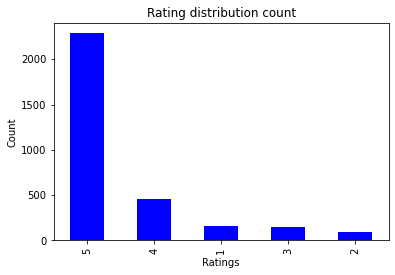

In [17]:
data['rating'].value_counts().plot.bar(color = 'blue')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [18]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


C:\Users\BALA\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1859: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


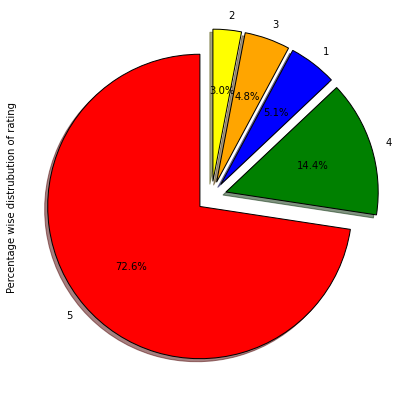

In [19]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [20]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [21]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [22]:
review_0 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_0)

Loved it!


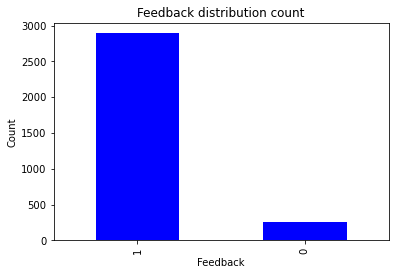

In [23]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [24]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<AxesSubplot:ylabel='Percentage wise distrubution of feedback'>

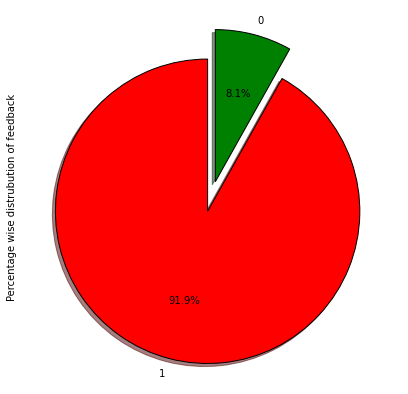

In [25]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [26]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [27]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [28]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


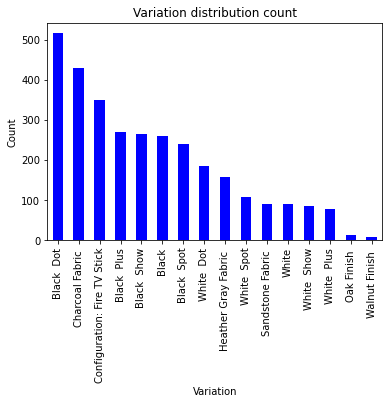

In [29]:
data['variation'].value_counts().plot.bar(color = 'blue')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [30]:
data['variation'].value_counts()/data.shape[0]*100

variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: count, dtype: float64

In [31]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

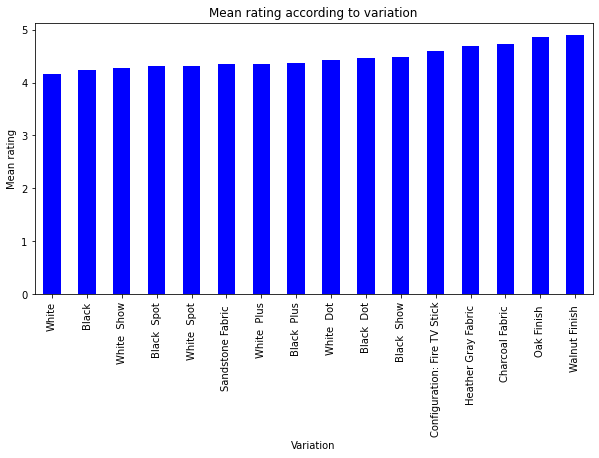

In [32]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'blue', figsize=(10, 5))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

Feature Engineering

In [33]:
data['length'] = data['verified_reviews'].apply(len)
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


In [34]:
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") 

'verified_reviews' column value: I sent it to my 85 year old Dad, and he talks to it constantly.


In [35]:
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") 

Length of review : 63


In [36]:
print(f"'length' column value : {data.iloc[10]['length']}")

'length' column value : 63


Adding New Column

In [37]:
def classify_sentiment(rating):
    if rating in [5, 4]:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:  
        return 'Negative'

data['sentiment'] = data['rating'].apply(classify_sentiment)
data

,rating,date,variation,verified_reviews,feedback,length,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,5,Positive
...,...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50,Positive
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135,Positive
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441,Positive
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380,Positive


In [38]:
data['sentiment'].value_counts()

sentiment
Positive    2741
Negative     256
Neutral      152
Name: count, dtype: int64

In [39]:
positive_rev = data[data['sentiment'] == 'Positive'][['verified_reviews']].head(5)
positive_rev

,verified_reviews
0,Love my Echo!
1,Loved it!
2,"Sometimes while playing a game, you can answer..."
3,I have had a lot of fun with this thing. My 4 ...
4,Music


In [40]:
neutral_rev = data[data['sentiment'] == 'Neutral'][['verified_reviews']].head(5)
neutral_rev

,verified_reviews
6,"Without having a cellphone, I cannot use many ..."
24,"I got a second unit for the bedroom, I was exp..."
33,The speakers sound pretty good for being so sm...
49,No different than Apple. To play a specific li...
54,like google better


In [41]:
negative_rev = data[data['sentiment'] == 'Negative'][['verified_reviews']].head(5)
negative_rev

,verified_reviews
46,"It's like Siri, in fact, Siri answers more acc..."
111,Sound is terrible if u want good music too get...
141,Not much features.
162,"Stopped working after 2 weeks ,didn't follow c..."
176,Sad joke. Worthless.


In [42]:
neg_reviews = " ".join([review for review in data[data['sentiment'] == 'Negative']['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

neu_reviews = " ".join([review for review in data[data['sentiment'] == 'Neutral']['verified_reviews']])
neu_reviews = neu_reviews.lower().split()


pos_reviews = " ".join([review for review in data[data['sentiment'] == 'Positive']['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_neutral = [x for x in neg_reviews if x not in neu_reviews]
unique_neutral = " ".join(unique_neutral)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

Data PreProcessing

In [44]:
corpus = []
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

for i in range(0, data.shape[0]):
    review = data.iloc[i]['verified_reviews']
    review = review.translate(str.maketrans('', '', string.punctuation))
    review = re.sub('[^a-zA-Z ]', ' ', review)
    review = review.lower().split()
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000) 
X = tfidf.fit_transform(corpus).toarray()

print(X.shape)

(3149, 3821)


In [46]:
data['cleaned_review'] = corpus

print(data[['verified_reviews', 'cleaned_review']].head())

                                    verified_reviews  \
0                                      Love my Echo!   
1                                          Loved it!   
2  Sometimes while playing a game, you can answer...   
3  I have had a lot of fun with this thing. My 4 ...   
4                                              Music   

                                      cleaned_review  
0                                          love echo  
1                                              loved  
2  sometimes playing game answer question correct...  
3  lot fun thing yr old learns dinosaur control l...  
4                                              music  


In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['sentiment_encoded'] = le.fit_transform(data['sentiment'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

print(data[['sentiment', 'sentiment_encoded']].drop_duplicates())

Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
   sentiment  sentiment_encoded
0   Positive                  2
6    Neutral                  1
46  Negative                  0


In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score


X = data['cleaned_review']
y = data['sentiment_encoded']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') 

print("Accuracy:", round(accuracy, 4))
print("F1 Score:", round(f1, 4))

Accuracy: 0.8746
F1 Score: 0.821


In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("\n🔹 Decision Tree")
print("Accuracy:", round(accuracy_dt, 4))
print("F1 Score:", round(f1_dt, 4))


🔹 Decision Tree
Accuracy: 0.8841
F1 Score: 0.8799


In [50]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

print("\n🔹 SVM")
print("Accuracy:", round(accuracy_svm, 4))
print("F1 Score:", round(f1_svm, 4))


🔹 SVM
Accuracy: 0.8889
F1 Score: 0.851


In [51]:
import pickle

with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [52]:
with open('svm_model.pkl', 'rb') as file:
    loaded_svm_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    loaded_tfidf = pickle.load(file)